In [1]:
# load libaries
import os
import SimpleITK as sitk
from skimage.transform import radon, iradon
from scipy.ndimage import gaussian_filter
import inspect
import warnings
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from perlin_noise import PerlinNoise
import torch
import torch.nn as nn
from torch.optim import Adam
from scipy.ndimage import rotate
import cv2
from skimage.restoration import denoise_tv_chambolle


# Import the DIP repository, make sure to clone https://github.com/DmitryUlyanov/deep-image-prior
import sys
sys.path.append('C:/Users/Administrator/deep-image-prior')
from models import skip

In [ ]:
import numpy as np
print(np.__version__)

In [2]:
# Helper Functions

def generate_sinogram_2d(image_2d, angles):
    # Get image dimensions
    rows, cols = image_2d.shape
    # Calculate the radius of the circle
    radius = min(rows, cols) // 2
    # Create a mask to zero out areas outside the circle
    Y, X = np.ogrid[:rows, :cols]
    center_y, center_x = rows / 2, cols / 2
    mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
    image_masked = image_2d * mask
    # Generate sinogram
    sinogram = radon(image_masked, theta=angles, circle=True)
    return sinogram


def add_poisson_noise(sinogram, scale=1e4):
    # Ensure there are no negative values (Poisson noise requires non-negative input)
    sinogram_clipped = np.clip(sinogram, 0, None)
    
    # Scale up the intensity values to approximate "photon counts"
    sinogram_scaled = sinogram_clipped * scale
    
    # Generate Poisson noise (random photon counts)
    sinogram_noisy_scaled = np.random.poisson(sinogram_scaled).astype(np.float32)
    
    # Scale back down to the original magnitude
    sinogram_noisy = sinogram_noisy_scaled / scale
    
    return sinogram_noisy


def backproject(sinogram, angles):
    reconstructed = np.zeros((sinogram.shape[1], sinogram.shape[1]))
    for i, angle in enumerate(angles):
        rotated_projection = rotate(np.tile(sinogram[i], (sinogram.shape[1], 1)).T, -angle, reshape=False)
        reconstructed += rotated_projection
    return reconstructed / len(angles)


def generate_sinogram(image, num_angles=180):
    angles = np.linspace(0, 180, num_angles, endpoint=False)
    sinogram = np.array([np.sum(rotate(image, angle, reshape=False), axis=0) for angle in angles])
    return sinogram, angles


def MLEM_reconstruction(sinogram, angles, num_iterations=50):
    # Initialize the image with ones
    image_shape = (sinogram.shape[1], sinogram.shape[1])  # Square image
    reconstructed = np.ones(image_shape, dtype=np.float32)

    # Small constant to avoid division by zero
    epsilon = 1e-6

    for iteration in range(num_iterations):
        # E-Step: Forward projection
        forward_projection = radon(reconstructed, theta=angles, circle=True)

        # Ensure matching shapes for division
        if forward_projection.shape != sinogram.shape:
            forward_projection = forward_projection[: sinogram.shape[0], :]

        # Compute the ratio
        ratio = sinogram / (forward_projection + epsilon)

        # M-Step: Backprojection of the ratio
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        # Update the reconstructed image
        reconstructed *= back_projection

        # Regularization to ensure non-negative image
        reconstructed = np.maximum(reconstructed, 0)

        # Debugging/logging iteration progress
        # print(f"MLEM Iteration {iteration + 1}/{num_iterations} complete.")

    return reconstructed

In [3]:
# NR1 KEM Implementation 
# use a simple gaussian kernel 

def KEM_model(sinogram, initial_shape, angles, sigma=1.0, num_iterations=10):
    # Initialize the image to all ones
    image_shape = initial_shape.shape
    reconstructed = np.ones(image_shape, dtype=np.float32)
    
    # Generate a Gaussian kernel for refinement
    kernel = gaussian_filter(np.ones_like(reconstructed), sigma=sigma)

    # Small constant to avoid division by zero
    epsilon = 1e-8

    for i in range(num_iterations):
        # E-Step: Forward projection
        forward_projection = radon(reconstructed, theta=angles, circle=True)

        # Compute the ratio between the measured and projected data
        ratio = sinogram / (forward_projection + epsilon)

        # M-Step: Backprojection of the ratio
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        # Update the reconstructed image using the kernel
        reconstructed *= back_projection * kernel

        # Regularization: Ensure non-negative values
        reconstructed = np.maximum(reconstructed, 0)

        # Debugging/logging iteration progress
        #print(f"KEM Iteration {i + 1}/{num_iterations} complete.")

    return reconstructed


In [4]:
# DIP Regularization
def DIP_regularization(image, num_iterations=500):
    input_depth = 1
    device = torch.device("cpu")  # Explicitly set the device to CPU

    # Define the DIP network and move it to CPU
    net = skip(
        input_depth, 1,
        num_channels_down=[16, 32, 64, 128, 128],
        num_channels_up=[16, 32, 64, 128, 128],
        num_channels_skip=[4, 4, 4, 4, 4],
        upsample_mode='bilinear',
        need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU'
    ).to(device)

    # Input to DIP (random noise) on CPU
    input_noise = torch.randn(1, input_depth, image.shape[0], image.shape[1]).to(device)

    # Define optimizer and loss
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    mse_loss = torch.nn.MSELoss()

    # Convert the image to a PyTorch tensor on CPU
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # DIP optimization loop
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = net(input_noise)
        loss = mse_loss(output, image_tensor)
        loss.backward()
        optimizer.step()

    # Convert the output back to a NumPy array for visualization
    output_image = output.detach().cpu().squeeze().numpy()
    return output_image

In [5]:
## Dicom reader
def load_dicom_series(folder_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
    if not dicom_names:
        raise ValueError(f"No DICOM files found in {folder_path}")
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def normalize_image(image):
    img_array = sitk.GetArrayFromImage(image).astype(np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    if img_max - img_min < 1e-5:
        return np.zeros_like(img_array)
    else:
        return (img_array - img_min) / (img_max - img_min)

In [6]:
## Image registration
def register_pet_ct(ct_image, pet_image, mode="upsample_PET"):
    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()

    # Set multi-resolution pyramid strategy
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set registration metric
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # Set transformation type (rigid transformation)
    initial_transform = sitk.CenteredTransformInitializer(
        ct_image,
        pet_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Set optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                      numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6,
                                                      convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Set interpolation method
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Perform registration
    #print("\nStarting registration...")
    try:
        final_transform = registration_method.Execute(sitk.Cast(ct_image, sitk.sitkFloat32),
                                                      sitk.Cast(pet_image, sitk.sitkFloat32))

        #print("\nRegistration completed.")
        print("Optimizer Converged:", registration_method.GetOptimizerStopConditionDescription())
        print("Final Metric Value:", registration_method.GetMetricValue())
    except Exception as e:
        print(f"\nRegistration failed: {e}")
        raise e

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(final_transform)

    if mode == "upsample_PET":
        resampler.SetReferenceImage(ct_image)
        #print("\nResampling PET image to CT space...")
        pet_resampled = resampler.Execute(pet_image)
        print("Resampling completed.")
        return ct_image, pet_resampled

    elif mode == "downsample_CT":
        resampler.SetReferenceImage(pet_image)
        #print("\nResampling CT image to PET space...")
        ct_resampled = resampler.Execute(ct_image)
        print("Resampling completed.")
        return ct_resampled, pet_image

    else:
        raise ValueError("Invalid mode selection, mode should be 'upsample_PET' or 'downsample_CT'")

In [7]:
# Design for Bowsher prior Filter 

def apply_bayesian_filter(image_2d, sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001):
    # Compute the Bayesian kernel (Bowsher-like prior)
    kernel = compute_bowsher_kernel_2d(image_2d, zeta=zeta, rho=rho, alpha=alpha)

    # Apply the kernel to the image
    filtered_image = image_2d * kernel

    return filtered_image

# Example Kernel computation functions for Bayesian method
def compute_kernel_2d(ct_2d, sigma=1.0):
    # Compute the gradient of the CT image
    gradient_x = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_y = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Design a bilateral kernel, assigning lower weights to edges
    kernel = np.exp(- (gradient_magnitude ** 2))
    return kernel

def psi(u, zeta=0.5, rho=0.01):
    """
    Smooth weighting function as described in the Bowsher-like prior.
    psi(u) = (1/pi) * arctan((zeta - u) / rho) + 0.5
    
    Parameters
    ----------
    u : float or np.ndarray
        The normalized intensity difference.
    zeta : float
        Controls the 'threshold' position in the arctan function.
    rho : float
        Controls the smoothness (slope) in the transition.
    
    Returns
    -------
    float or np.ndarray
        The weight in [0,1] range after applying the arctan-based mapping.
    """
    return (np.arctan((zeta - u) / rho) / np.pi) + 0.5

def Tq_linear(value):
    return value


def compute_bowsher_kernel_2d(
    ct_image_2d, 
    zeta=0.5, 
    rho=0.01, 
    Tq_func=Tq_linear, 
    epsilon=1e-6,
    alpha = 0.001
):
    # Offsets for the 8 neighbors in (dy, dx)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    
    H, W = ct_image_2d.shape
    weights_2d = np.zeros((H, W, len(neighbor_offsets)), dtype=np.float32)

    # Pre-compute Tq for the entire image to avoid repeated calls
    transformed_ct = Tq_func(ct_image_2d)

    # For each pixel, we need M_j = max|Tq(mu_j) - Tq(mu_k)| over neighbors
    # We'll store that in an array for quick access
    M_array = np.zeros((H, W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            diffs = []
            for dy, dx in neighbor_offsets:
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W:
                    neighbor_val = transformed_ct[ny, nx]
                    diffs.append(abs(central_val - neighbor_val))
            if len(diffs) > 0:
                M_array[y, x] = max(diffs)
            else:
                M_array[y, x] = 0.0

    # Compute the actual weights for each neighbor
    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            Mj = M_array[y, x]
            
            for n_idx, (dy, dx) in enumerate(neighbor_offsets):
                ny, nx = y + dy, x + dx
                if not (0 <= ny < H and 0 <= nx < W):
                    # Out of bounds, weight = 0
                    weights_2d[y, x, n_idx] = 0.0
                    continue
                
                neighbor_val = transformed_ct[ny, nx]
                Mk = M_array[ny, nx]
                
                denom = (Mj + Mk) / 2.0
                denom = denom if denom > epsilon else epsilon
                
                diff = abs(central_val - neighbor_val)
                u_jk = diff / denom
                
                w_jk = psi(u_jk, zeta=zeta, rho=rho)
                weights_2d[y, x, n_idx] = w_jk

    kernel = np.sum(weights_2d, axis=-1)
    kernel = np.exp(alpha * kernel) # exp
    #kernel = 1.0 / (1.0 + np.exp(-alpha * kernel)) #sigmoid
    
    return kernel

In [24]:
## Hybrid Model Nr 2 KEM + DIP with different kernel

def project(image, angles):
    # Forward projection function (e.g., Radon transform)
    return radon(image, theta=angles, circle=True)

def backproject(sinogram, angles):
    # Backprojection function (e.g., filtered or unfiltered backprojection)
     return iradon(sinogram, theta=angles, circle=True)

def generate_perlin_noise(size):
    noise = PerlinNoise(octaves=4)  # Corrected: single integer
    perlin_map = [[noise([i/size[0], j/size[1]]) for j in range(size[1])] for i in range(size[0])]
    return torch.tensor(perlin_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape (1,1,H,W)



def apply_filter(image, method="bilateral", sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001):
    """
    Parameters:
    - image: Torch tensor (grayscale, shape [H, W])
    - method: "bilateral" for bilateral filtering, "anisotropic" for anisotropic diffusion, "gaussian" for Gaussian filtering, "bayesian" for Bowsher-like prior.
    - sigma: Parameter controlling smoothing intensity.
    - zeta, rho, alpha: Parameters for Bayesian (Bowsher-like) kernel design.
    
    Returns:
    - filtered_image: Filtered image as a torch tensor.
    """
    image_np = image.detach().cpu().numpy()  # Use .detach() to remove gradients

    if method == "bilateral":
        # Bilateral filter (preserves edges while reducing noise)
        filtered_image = cv2.bilateralFilter(image_np.astype(np.float32), d=9, sigmaColor=sigma*50, sigmaSpace=sigma*50)
    
    elif method == "anisotropic":
        # Anisotropic diffusion (Total Variation denoising)
        filtered_image = denoise_tv_chambolle(image_np, weight=sigma)
    
    elif method == "gaussian":
        # Gaussian filter
        filtered_image = gaussian_filter(image_np, sigma=sigma)
    
    elif method == "bayesian":
        # Bayesian kernel (Bowsher-like prior)
        filtered_image = apply_bayesian_filter(image_np, sigma=sigma, zeta=zeta, rho=rho, alpha=alpha)
    
    else:
        raise ValueError("Invalid method. Choose 'bilateral', 'anisotropic', 'gaussian', or 'bayesian'.")

    return torch.tensor(filtered_image, dtype=torch.float32).to(image.device)


def total_variation_loss_version1(image):
    tv_h = torch.sum(torch.abs(image[:, :, 1:, :] - image[:, :, :-1, :]))
    tv_w = torch.sum(torch.abs(image[:, :, :, 1:] - image[:, :, :, :-1]))
    return tv_h + tv_w


def total_variation_loss_version2(img):
    diff1 = torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])
    diff2 = torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :])
    return torch.sum(diff1) + torch.sum(diff2)



def KEM_step(image, sinogram, angles, kernel_size, sigma=1.0, filter_method="bilateral"):
    device = image.device

    # Step 1: Forward project the image (detach to prevent gradient issues)
    forward_projection = project(image.squeeze().detach().cpu().numpy(), angles)  
    forward_projection = torch.tensor(forward_projection, dtype=torch.float32).to(device)

    # Step 2: Compute correction term
    ratio = sinogram / (forward_projection + 1e-8)
    ratio = ratio.clamp(min=0, max=10)

    # Backproject the correction term
    back_projection = backproject(ratio.cpu().numpy(), angles)
    back_projection = torch.tensor(back_projection, dtype=torch.float32).to(device)

    # Step 3: Apply chosen filtering method
    smoothed_image = apply_filter(image.squeeze(), method=filter_method, sigma=sigma)
    if isinstance(smoothed_image, np.ndarray):  # If it's a NumPy array
        smoothed_image = torch.from_numpy(smoothed_image).float().to(device)
    else:  # If it's already a tensor
        smoothed_image = smoothed_image.clone().detach().to(device)

    # Step 4: Update image
    updated_image = smoothed_image * back_projection
    updated_image = updated_image / updated_image.max()

    return updated_image.unsqueeze(0).unsqueeze(0)


def model2(sinogram, angles, ct_image, kernel_size, num_iterations=10, dip_iterations=100, sigma=1.0, filter="bilateral"):
  
    device = torch.device("cpu")  # Use CPU for computation

    # Initialize image with FBP reconstruction
    initial_image = backproject(sinogram, angles)
    current_image = torch.tensor(initial_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Normalize and resize CT prior
    ct_image = torch.tensor(ct_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    ct_image = (ct_image - ct_image.min()) / (ct_image.max() - ct_image.min())  # Normalize to [0,1]
    
    if ct_image.shape != current_image.shape:
        ct_image = torch.nn.functional.interpolate(ct_image, size=current_image.shape[2:], mode="bilinear", align_corners=False)

    # Define DIP network
    input_depth = 2 # one channel for noise or FBP, one for CT prior
    net = skip(
        input_depth, 1,
        num_channels_down=[16, 32, 64, 128, 128],
        num_channels_up=[16, 32, 64, 128, 128],
        num_channels_skip=[4, 4, 4, 4, 4],
        upsample_mode='bilinear',
        need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU'
    ).to(device)

    # Define optimizer for DIP
    optimizer = torch.optim.Adam(net.parameters(), lr=0.008) # explore different learning rate lr= [0.001, 0.01]
    mse_loss = torch.nn.MSELoss()

    # anatomical_prior = ct_image.clone().detach().unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, H, W]
    
    # Create random noise input for DIP as input z
    # input_noise = torch.randn(1, input_depth, current_image.shape[2], current_image.shape[3]).to(device)

    # DIP input (multi-channel: noise + CT) 
    # Different noise to test as input
    # input_noise = torch.randn(1, 1, current_image.shape[2], current_image.shape[3]).to(device)
    # perlin_noise = generate_perlin_noise((current_image.shape[2], current_image.shape[3])).to(device)

    # multi_channel_input = torch.cat((input_noise, ct_image), dim=1)  # randon noise + CT okayish
    # multi_channel_input = torch.cat((perlin_noise, ct_image), dim=1) # Perlin noise + CT this is very bad!
    multi_channel_input = torch.cat((current_image, ct_image), dim=1)  # FBP + CT is the best 

    for i in range(num_iterations):
        # Perform one iteration of KEM
        kem_output = KEM_step(current_image, sinogram, angles, kernel_size, sigma, filter_method=filter)

        # Update current_image with KEM output
        current_image = kem_output.clone()

        # Update DIP iterations adaptively (increase over time)
        #current_dip_iterations = dip_iterations + (i * 10)  # Increase DIP steps over iterations

        # Increase alpha value over iterations (start low, increase gradually)
        #alpha = min(0.1 + (i / num_iterations) * 0.9, 1.0)

        # Apply DIP regularization
        for _ in range(dip_iterations): # current_dip_iterations    dip_iterations
            optimizer.zero_grad()
            dip_output = net(multi_channel_input) # input_noise
            
            # Combine KEM fidelity loss and DIP regularization loss
            fidelity_loss = mse_loss(dip_output, kem_output)

            # Convert tensors to NumPy for SSIM calculation
            dip_np = dip_output.squeeze().detach().cpu().numpy()
            ct_np = ct_image.squeeze().detach().cpu().numpy()

            # Fidelity loss (KEM consistency)
            fidelity_loss = mse_loss(dip_output, kem_output)

            # Structural similarity loss (align with CT)
            # Structural similarity loss (align with CT)
            ssim_loss = 1 - ssim(dip_np, ct_np, data_range=1.0)  
            total_loss = fidelity_loss + 0.1 * ssim_loss  # Weighted loss function
            total_loss.backward()


            #dip_loss = fidelity_loss  # Additional regularization loss could be added
            #dip_loss.backward()
            optimizer.step()

        # Weighted combination of KEM and DIP output
        # current_image = alpha * dip_output + (1 - alpha) * kem_output
        current_image = dip_output.detach()

    # Convert final image to NumPy array for visualization
    final_image = current_image.squeeze().detach().cpu().numpy()
    return final_image


In [9]:
## Different loss functions 

"""
# Apply DIP regularization


        for _ in range(dip_iterations): # current_dip_iterations    dip_iterations
            optimizer.zero_grad()
            dip_output = net(multi_channel_input) # input_noise
            
            # Combine KEM fidelity loss and DIP regularization loss
            fidelity_loss = mse_loss(dip_output, kem_output)

            # Convert tensors to NumPy for SSIM calculation
            dip_np = dip_output.squeeze().detach().cpu().numpy()
            ct_np = ct_image.squeeze().detach().cpu().numpy()

            # Fidelity loss (KEM consistency)
            fidelity_loss = mse_loss(dip_output, kem_output)

            # Structural similarity loss (align with CT)
            ssim_loss = 1 - ssim(dip_np, ct_np, data_range=1.0)  
            total_loss = fidelity_loss + 0.1 * ssim_loss  # Weighted loss function
            total_loss.backward()

            #dip_loss = fidelity_loss  # Additional regularization loss could be added
            #dip_loss.backward()
            optimizer.step()




# Apply DIP regularization
        for _ in range(dip_iterations): # current_dip_iterations    dip_iterations
            optimizer.zero_grad()
            dip_output = net(multi_channel_input) # input_noise
            
            # Combine KEM fidelity loss and DIP regularization loss
            fidelity_loss = mse_loss(dip_output, kem_output) # MSE (DIP vs KEM)
            tv_loss = total_variation_loss_version1(dip_output)        # TV Loss (Smoothness)

            # Convert tensors to NumPy for SSIM calculation
            dip_np = dip_output.squeeze().detach().cpu().numpy()
            ct_np = anatomical_prior.squeeze().detach().cpu().numpy()
            ssim_loss = 1 - ssim(dip_np, ct_np, data_range=1.0)  # SSIM DIP vs CT

            # Weighted Loss Function
            λ1, λ2, λ3 = 0.01, 0.01, 0.01  # Adjust weights as needed
            total_loss = λ1 * fidelity_loss + λ2 * tv_loss + λ3 * ssim_loss

            # Backpropagation
            total_loss.backward()
    

            # dip_loss = fidelity_loss  # Additional regularization loss could be added
            # dip_loss.backward()
            optimizer.step()


# Instead of operating in the spatial domain, train DIP to match sinograms in the Fourier domain
dip_fft = torch.fft.fft2(dip_output)
kem_fft = torch.fft.fft2(kem_output)
frequency_loss = mse_loss(dip_fft, kem_fft)
total_loss = fidelity_loss + 0.1 * ssim_loss + 0.05 * frequency_loss

"""

'\n# Apply DIP regularization\n\n\n        for _ in range(dip_iterations): # current_dip_iterations    dip_iterations\n            optimizer.zero_grad()\n            dip_output = net(multi_channel_input) # input_noise\n            \n            # Combine KEM fidelity loss and DIP regularization loss\n            fidelity_loss = mse_loss(dip_output, kem_output)\n\n            # Convert tensors to NumPy for SSIM calculation\n            dip_np = dip_output.squeeze().detach().cpu().numpy()\n            ct_np = ct_image.squeeze().detach().cpu().numpy()\n\n            # Fidelity loss (KEM consistency)\n            fidelity_loss = mse_loss(dip_output, kem_output)\n\n            # Structural similarity loss (align with CT)\n            ssim_loss = 1 - ssim(dip_np, ct_np, data_range=1.0)  \n            total_loss = fidelity_loss + 0.1 * ssim_loss  # Weighted loss function\n            total_loss.backward()\n\n            #dip_loss = fidelity_loss  # Additional regularization loss could be adde

In [25]:
# Evaluation
def evaluate_reconstruction(ground_truth, reconstructed):
    """
    Evaluate reconstruction quality using MSE, PSNR, and SSIM.
    """
    mse_val = mse(ground_truth, reconstructed)
    ssim_val = ssim(ground_truth, reconstructed, data_range=ground_truth.max() - ground_truth.min())
    psnr_val = 20 * np.log10(ground_truth.max() / np.sqrt(mse_val))
    rmse_val = np.sqrt(mse(ground_truth, reconstructed))
    return mse_val, psnr_val, ssim_val, rmse_val

In [11]:
# Load an example image
ct_folder_path = r"C:\Users\Administrator\OneDrive - stud.hs-mannheim.de\Dokumente\PCC3\NIH\CT\CT_1.3.6.1.4.1.14519.5.2.1.7009.2403.192241118078441962132923230489"
pet_folder_path = r"C:\Users\Administrator\OneDrive - stud.hs-mannheim.de\Dokumente\PCC3\NIH\CT\PT_1.3.6.1.4.1.14519.5.2.1.7009.2403.121694709831221676480030303736"

# Load images
print("Loading CT image...")
ct_image = load_dicom_series(ct_folder_path)
print("Loading PET image...")
pet_image = load_dicom_series(pet_folder_path)

# Print image information
def print_image_info(name, image):
    print(f"\n{name} Image Information:")
    print(f"  Size: {image.GetSize()}")
    print(f"  Spacing: {image.GetSpacing()}")
    print(f"  Origin: {image.GetOrigin()}")
    print(f"  Direction: {image.GetDirection()}")
    print(f"  Dimension: {image.GetDimension()}")

print_image_info("CT", ct_image)
print_image_info("PET", pet_image)

# Ensure both are 3D images
if ct_image.GetDimension() != 3 or pet_image.GetDimension() != 3:
    raise ValueError("Both CT and PET images must be 3D.")

# Ensure both are float32
ct_image = sitk.Cast(ct_image, sitk.sitkFloat32)
pet_image = sitk.Cast(pet_image, sitk.sitkFloat32)


#mode = "upsample_PET"
mode = "downsample_CT"
ct_image_resampled, pet_image_resampled = register_pet_ct(ct_image, pet_image, mode=mode)

# ================== 3) Select Middle Slice and Generate Sinogram ==================

# Select middle slice
ct_array = sitk.GetArrayFromImage(ct_image_resampled)  # shape: [slices, height, width]
pet_array = sitk.GetArrayFromImage(pet_image_resampled)  # shape: [slices, height, width]

middle_slice_idx = ct_array.shape[0] // 2
ct_slice = ct_array[middle_slice_idx, :, :]
pet_slice = pet_array[middle_slice_idx, :, :]

# Normalize
ct_norm = normalize_image(ct_image_resampled)
pet_norm = normalize_image(pet_image_resampled)
ct_slice_norm = ct_norm[middle_slice_idx, :, :]
pet_slice_norm = pet_norm[middle_slice_idx, :, :]
initial_kernel_size = ct_slice_norm

# Generate sinogram
angles = np.linspace(0., 180., max(ct_slice.shape), endpoint=False)
pet_sinogram = generate_sinogram_2d(pet_slice_norm, angles)
pet_sinogram = add_poisson_noise(pet_sinogram, scale=1e3)


Loading CT image...
Loading PET image...

CT Image Information:
  Size: (512, 512, 307)
  Spacing: (0.9765625, 0.9765625, 2.5)
  Origin: (-249.51172, -460.51172, -1007.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3

PET Image Information:
  Size: (128, 128, 307)
  Spacing: (5.3067274, 5.3067274, 2.5)
  Origin: (-339.16485, -553.64165, -1007.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3
Optimizer Converged: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 34.
Final Metric Value: -0.35372351894991355
Resampling completed.


c:\ProgramData\Anaconda3\envs\recon\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


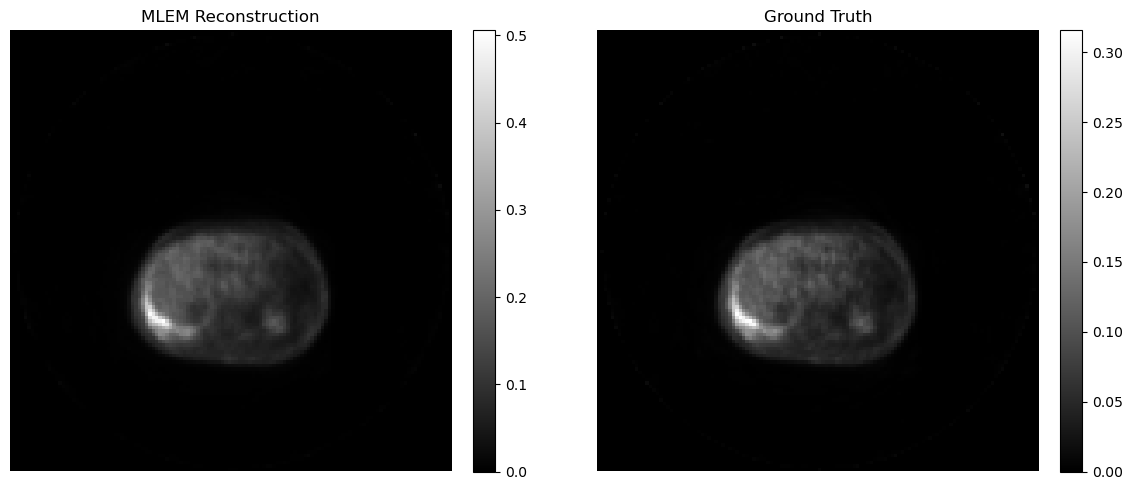

In [12]:
# MLEM Reconstruction for comparison
mlem_reconstructed = MLEM_reconstruction(pet_sinogram, angles)
ground_truth = pet_slice_norm

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
im1 = axes[0].imshow(mlem_reconstructed, cmap='gray')  
axes[0].set_title("MLEM Reconstruction")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  
im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  
plt.tight_layout()  
plt.show()

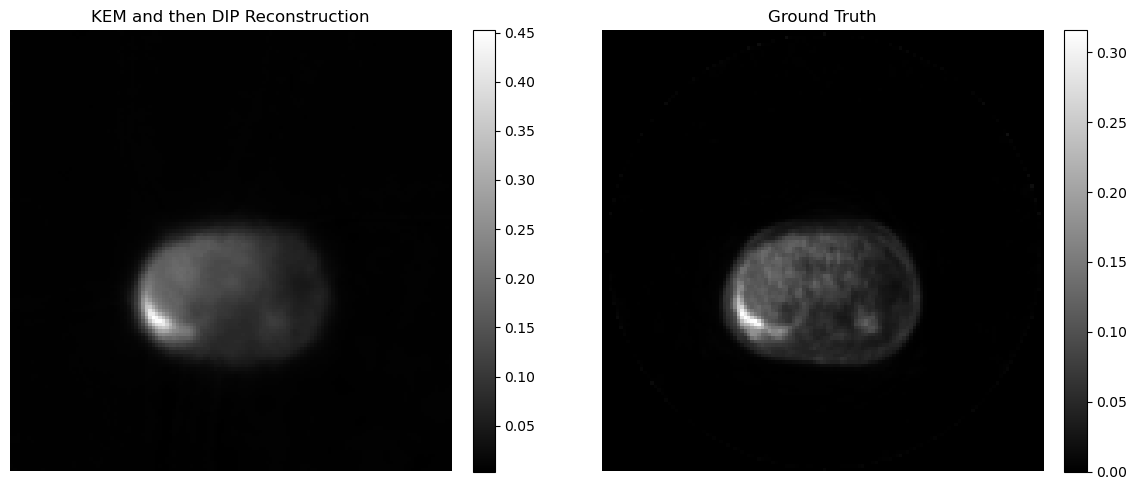

In [13]:
# Call Function Nr1 KEM with DIP Hybrid Reconstruction
fbp_initial = backproject(pet_sinogram, angles)

kem_output = KEM_model(pet_sinogram, initial_kernel_size, angles, sigma=1.0, num_iterations=10)
hybrid_output = DIP_regularization(kem_output)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Plot Hybrid (KEM + DIP) Reconstruction
im1 = axes[0].imshow(hybrid_output, cmap='gray')  
axes[0].set_title("KEM and then DIP Reconstruction")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

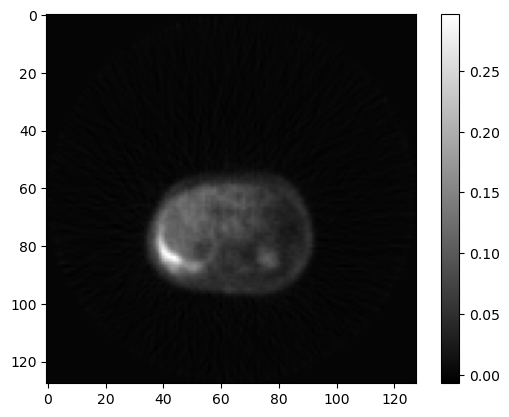

In [14]:
backp = backproject(pet_sinogram,angles)

plt.imshow(backp, cmap='gray')
plt.colorbar()
plt.show

c:\ProgramData\Anaconda3\envs\recon\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


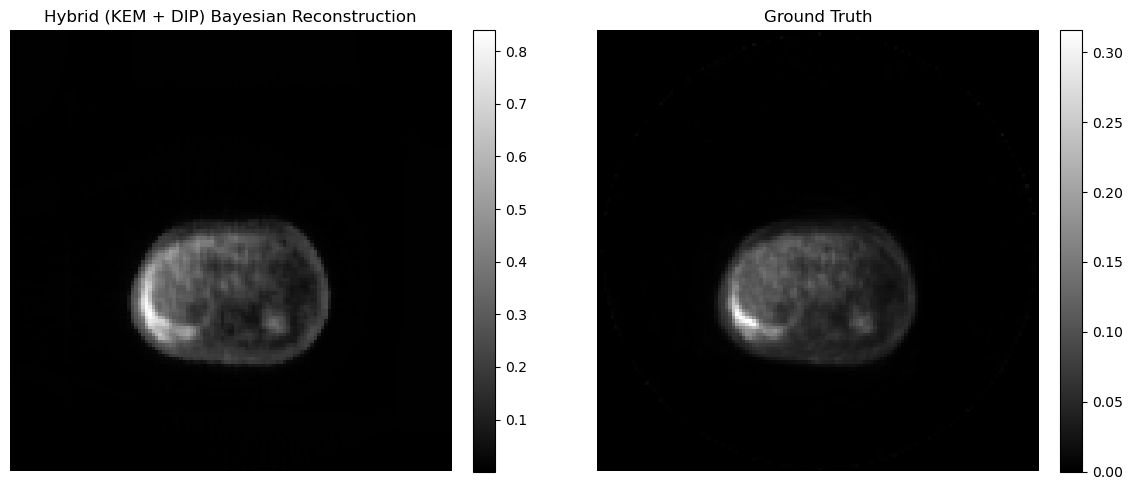

In [26]:
# Call FUnction Nr2 hybrid_KEM_DIP(sinogram, angles, kernel_size, num_iterations=10, dip_iterations=500, sigma=1.0)

# Set parameters for the hybrid KEM + DIP process
kernel_size = 5  # Example kernel size for KEM
num_iterations = 10  # Number of KEM iterations
dip_iterations = 100  # Number of DIP iterations per KEM step
sigma = 1.0  # Smoothing parameter for KEM

model2_outcome_bayesian = model2(pet_sinogram, angles, ct_slice,  kernel_size, num_iterations, dip_iterations, sigma, filter="bayesian")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
im1 = axes[0].imshow(model2_outcome_bayesian, cmap='gray')  
axes[0].set_title("Hybrid (KEM + DIP) Bayesian Reconstruction")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()


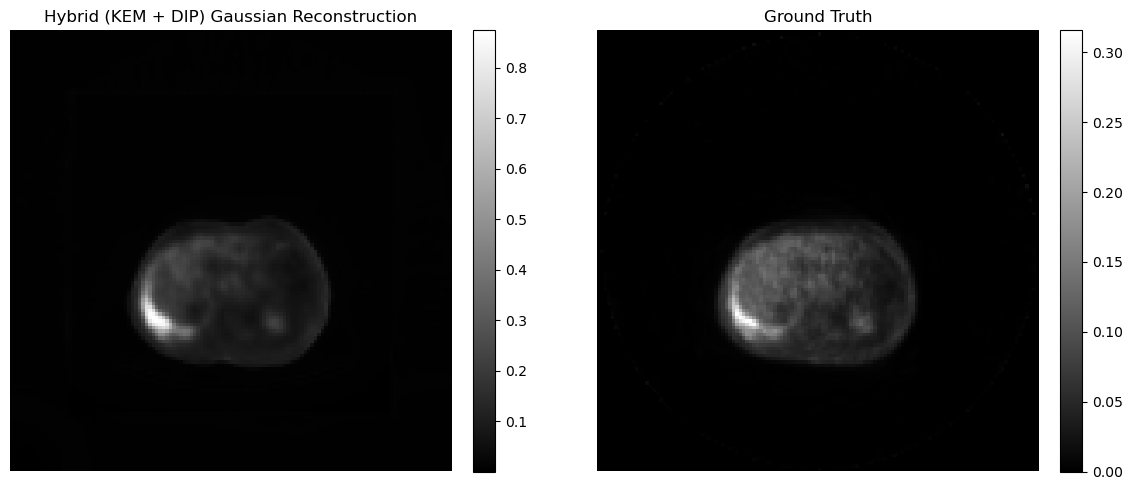

In [27]:
# Set parameters for the hybrid KEM + DIP process
kernel_size = 5  # Example kernel size for KEM
num_iterations = 10  # Number of KEM iterations
dip_iterations = 100  # Number of DIP iterations per KEM step
sigma = 1.0  # Smoothing parameter for KEM

model2_outcome_gaussian = model2(pet_sinogram, angles, ct_slice, kernel_size, num_iterations, dip_iterations, sigma, filter="gaussian")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
im1 = axes[0].imshow(model2_outcome_gaussian, cmap='gray')  
axes[0].set_title("Hybrid (KEM + DIP) Gaussian Reconstruction")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()

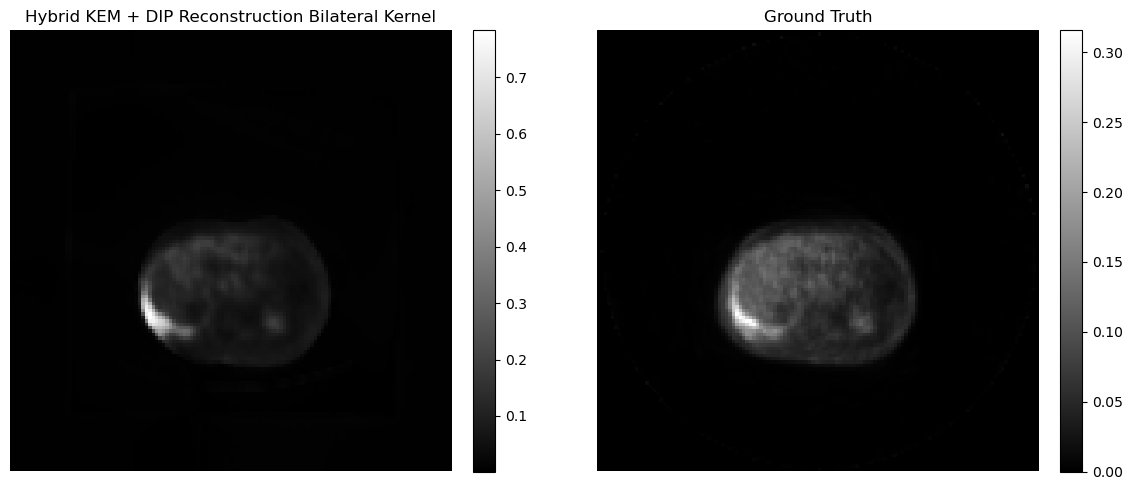

In [29]:
# Set parameters for the hybrid KEM + DIP process
kernel_size = 5  # Example kernel size for KEM
num_iterations = 10  # Number of KEM iterations
dip_iterations = 100  # Number of DIP iterations per KEM step
sigma = 1.0  # Smoothing parameter for KEM

model2_outcome_bilateral = model2(pet_sinogram, angles, ct_slice, kernel_size, num_iterations, dip_iterations, sigma, filter="bilateral")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
im1 = axes[0].imshow(model2_outcome_bilateral, cmap='gray')  
axes[0].set_title("Hybrid KEM + DIP Reconstruction Bilateral Kernel")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()



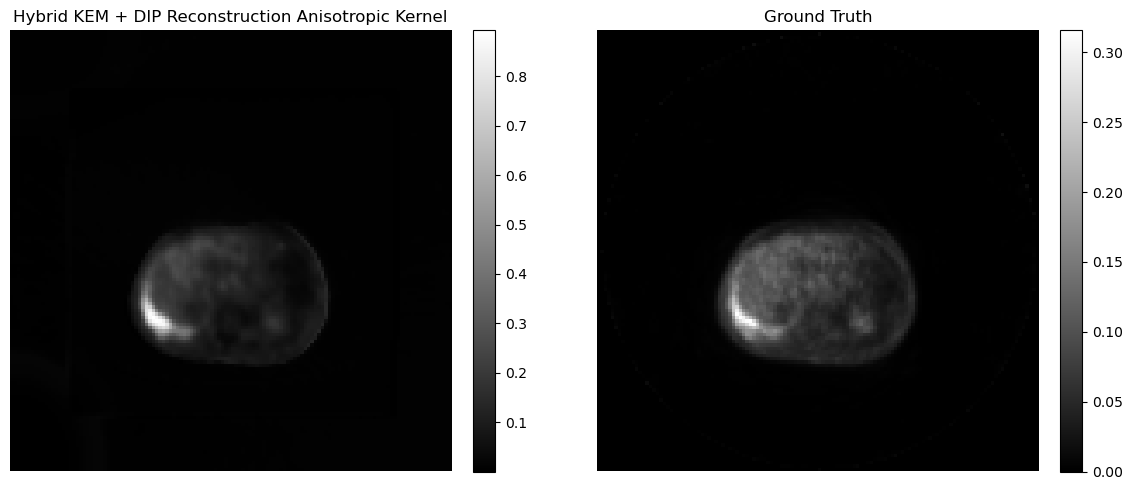

In [30]:
# Set parameters for the hybrid KEM + DIP process
kernel_size = 5  # Example kernel size for KEM
num_iterations = 10  # Number of KEM iterations
dip_iterations = 100  # Number of DIP iterations per KEM step
sigma = 1.0  # Smoothing parameter for KEM

model2_outcome_anisotrpic = model2(pet_sinogram, angles, ct_slice, kernel_size, num_iterations, dip_iterations, sigma, filter="anisotropic")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
im1 = axes[0].imshow(model2_outcome_anisotrpic, cmap='gray')  
axes[0].set_title("Hybrid KEM + DIP Reconstruction Anisotropic Kernel")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()


In [31]:
# Evaluate MLEM vs Hybrid
metrics_mlem = evaluate_reconstruction(ground_truth, mlem_reconstructed)
metrics_hybrid = evaluate_reconstruction(ground_truth, hybrid_output)
metrics_model2_outcome_gaussian = evaluate_reconstruction(ground_truth, model2_outcome_gaussian)
metrics_model2_outcome_bilateral = evaluate_reconstruction(ground_truth, model2_outcome_bilateral)
metrics_model2_outcome_anisotropic = evaluate_reconstruction(ground_truth, model2_outcome_anisotrpic)

print("MLEM Reconstruction Metrics:")
print(f"MSE: {metrics_mlem[0]:.4f}, PSNR: {metrics_mlem[1]:.2f}, SSIM: {metrics_mlem[2]:.4f}, RMSE: {metrics_mlem[3]:.4f}\n")

print("KEM + DIP Reconstruction Nr1 with Gaussian Kernel Metrics:")
print(f"MSE: {metrics_hybrid[0]:.4f}, PSNR: {metrics_hybrid[1]:.2f}, SSIM: {metrics_hybrid[2]:.4f}, RMSE: {metrics_hybrid[3]:.4f} \n")

print("Hybrid 2 (KEM + DIP) Reconstruction with Gaussian Kernel Metrics:")
print(f"MSE: {metrics_model2_outcome_gaussian[0]:.4f}, PSNR: {metrics_model2_outcome_gaussian[1]:.2f}, SSIM: {metrics_model2_outcome_gaussian[2]:.4f}, RMSE: {metrics_model2_outcome_gaussian[3]:.4f} \n")

print("Hybrid 2 (KEM + DIP) Reconstruction with Bilateral Kernel Metrics:")
print(f"MSE: {metrics_model2_outcome_bilateral[0]:.4f}, PSNR: {metrics_model2_outcome_bilateral[1]:.2f}, SSIM: {metrics_model2_outcome_bilateral[2]:.4f}, RMSE: {metrics_model2_outcome_bilateral[3]:.4f} \n")

print("Hybrid 2 (KEM + DIP) Reconstruction with Anisotropic Kernel Metrics:")
print(f"MSE: {metrics_model2_outcome_anisotropic[0]:.4f}, PSNR: {metrics_model2_outcome_anisotropic[1]:.2f}, SSIM: {metrics_model2_outcome_anisotropic[2]:.4f}, RMSE: {metrics_model2_outcome_anisotropic[3]:.4f} \n")



# SSIM = 1 → Perfect match with the reference image.
# SSIM > 0.9 → Excellent similarity, almost no perceptual difference.
# SSIM 0.7 - 0.9 → Good quality, but noticeable artifacts.
# SSIM 0.5 - 0.7 → Moderate degradation.
# SSIM < 0.5 → Significant structural differences and quality loss.

MLEM Reconstruction Metrics:
MSE: 0.0003, PSNR: 25.66, SSIM: 0.9598, RMSE: 0.0165

KEM + DIP Reconstruction Nr1 with Gaussian Kernel Metrics:
MSE: 0.0003, PSNR: 25.40, SSIM: 0.3713, RMSE: 0.0170 

Hybrid 2 (KEM + DIP) Reconstruction with Gaussian Kernel Metrics:
MSE: 0.0014, PSNR: 18.53, SSIM: 0.3362, RMSE: 0.0374 

Hybrid 2 (KEM + DIP) Reconstruction with Bilateral Kernel Metrics:
MSE: 0.0006, PSNR: 22.33, SSIM: 0.3973, RMSE: 0.0242 

Hybrid 2 (KEM + DIP) Reconstruction with Anisotropic Kernel Metrics:
MSE: 0.0012, PSNR: 19.08, SSIM: 0.4126, RMSE: 0.0351 



In [20]:
""""
# Plot Results
plt.figure(figsize=(12, 6))
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap='gray')
plt.colorbar
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.title("Difference MLEM - True")
plt.imshow(mlem_reconstructed-ground_truth)
plt.colorbar()
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.title("MLEM Reconstruction")
plt.imshow(mlem_reconstructed, cmap='gray')
plt.colorbar
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.title("Hybrid (KEM + DIP)")
plt.imshow(hybrid_output, cmap='gray')
plt.colorbar
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.title("Difference Hybrid - True")
plt.imshow(hybrid_output-ground_truth)
plt.colorbar()
plt.axis('off')

plt.show()

"""

'"\n# Plot Results\nplt.figure(figsize=(12, 6))\nplt.title("Ground Truth")\nplt.imshow(ground_truth, cmap=\'gray\')\nplt.colorbar\nplt.axis(\'off\')\n\nplt.figure(figsize=(12, 6))\nplt.title("Difference MLEM - True")\nplt.imshow(mlem_reconstructed-ground_truth)\nplt.colorbar()\nplt.axis(\'off\')\n\nplt.figure(figsize=(12, 6))\nplt.title("MLEM Reconstruction")\nplt.imshow(mlem_reconstructed, cmap=\'gray\')\nplt.colorbar\nplt.axis(\'off\')\n\nplt.figure(figsize=(12, 6))\nplt.title("Hybrid (KEM + DIP)")\nplt.imshow(hybrid_output, cmap=\'gray\')\nplt.colorbar\nplt.axis(\'off\')\n\nplt.figure(figsize=(12, 6))\nplt.title("Difference Hybrid - True")\nplt.imshow(hybrid_output-ground_truth)\nplt.colorbar()\nplt.axis(\'off\')\n\nplt.show()\n\n'

(-0.5, 127.5, 127.5, -0.5)

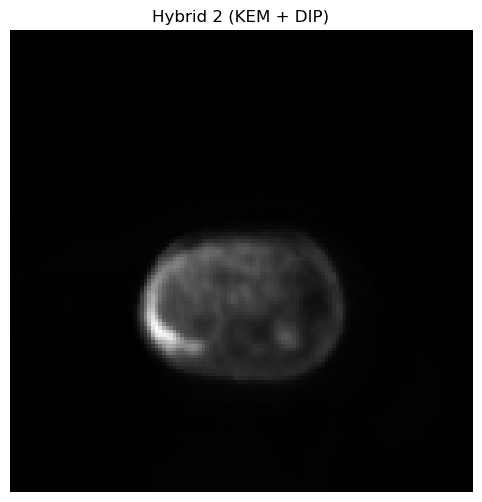

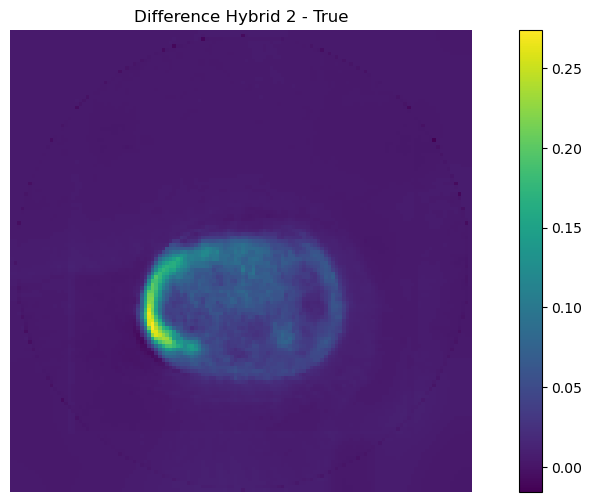

In [21]:
"""
plt.figure(figsize=(12, 6))
plt.title("Hybrid 2 (KEM + DIP)")
plt.imshow(model2_outcome_gaussian, cmap='gray')
plt.colorbar
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.title("Difference Hybrid 2 - True")
plt.imshow(model2_outcome_gaussian-ground_truth)
plt.colorbar
plt.colorbar()
plt.axis('off')

"""